In [1]:
# Let's import the libraries used in  this notebook

import pandas as pd # Good old pandas for data processing
# import numpy as np # Some maths, used here to deal with arrays
import pandas_profiling as pp # Pandas_profiling is a powerful, automated way of doing exploratory data analysis. https://github.com/pandas-profiling/pandas-profiling
import numpy as np

In [2]:
df = pd.read_excel('./data/Sample - Superstore.xls') # Let's read our file, for this problem it's a single one

In [54]:
pp.ProfileReport(df) # Let's give it straight to pandas-profiling 

Number of variables,21
Number of observations,9994
Total Missing (%),0.0%
Total size in memory,1.6 MiB
Average record size in memory,168.0 B
Numeric,6
Categorical,12
Boolean,0
Date,2
Text (Unique),0
Rejected,1


We have a problem, no dictonary is provided, and the column 'Sales' don't have a clear explantion. I think it means the revenue, in dollars, from that sale. It's also not clear what 'Profit' means, given we have some pretty big numbers I think it's a value in dollars and not percent. To check this we will use the definition of Profit to try to figure out.

Profit = Revenue - Cost  therefore Cost = Reveneu - Profit

Given that it's not possible to have a cost of zero, let's calculate 'Cost' and analyze it.

In [3]:
df['Cost'] = df.Sales - df.Profit

In [4]:
sorted(df.Cost, reverse=False)[:6]

[0.5543999999999999,
 0.6572,
 0.84,
 0.8400000000000001,
 0.8400000000000001,
 0.8736000000000002]

Success! We don't have a smaller than 0 value. Let's look at the distribution.

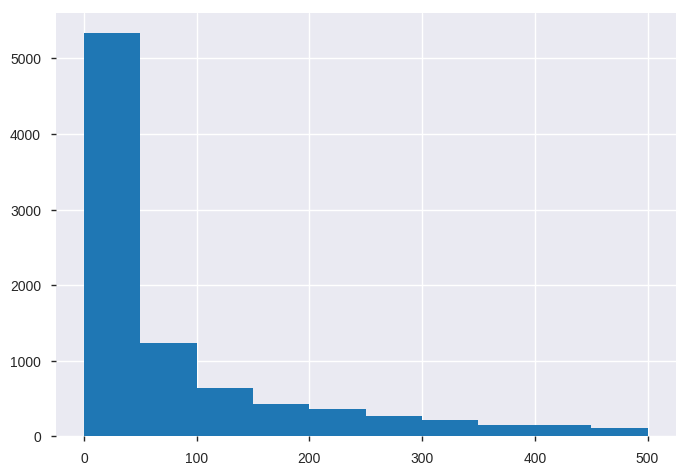

In [57]:
df.Cost.hist(range = (0, 500))

Looks about right. So let's aggregate the data by month and revenue. Since we will start with a model that only predicts the global revenue before categorizing the problem we will pick only a couple columns.

In [58]:
df.head(2)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Cost
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136,220.0464
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820,512.3580


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 22 columns):
Row ID           9994 non-null int64
Order ID         9994 non-null object
Order Date       9994 non-null datetime64[ns]
Ship Date        9994 non-null datetime64[ns]
Ship Mode        9994 non-null object
Customer ID      9994 non-null object
Customer Name    9994 non-null object
Segment          9994 non-null object
Country          9994 non-null object
City             9994 non-null object
State            9994 non-null object
Postal Code      9994 non-null int64
Region           9994 non-null object
Product ID       9994 non-null object
Category         9994 non-null object
Sub-Category     9994 non-null object
Product Name     9994 non-null object
Sales            9994 non-null float64
Quantity         9994 non-null int64
Discount         9994 non-null float64
Profit           9994 non-null float64
Cost             9994 non-null float64
dtypes: datetime64[ns](2), float64(4), i

In [5]:
df.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit', 'Cost'],
      dtype='object')

In [6]:
df.rename(columns=
               {'Row ID':'Row_ID',
                'Order ID':'Order_ID',
                'Order Date':'Order_Date',
                'Ship Date':'Ship_Date',
                'Ship Mode':'Ship_Mode',
                'Customer ID':'Customer_ID',
                'Customer Name':'Customer_Name',
                'Postal Code':'Postal_Code',
                'Product ID':'Product_ID',
                'Product Name':'Product_Name'}, inplace=True)

In [7]:
df.columns

Index(['Row_ID', 'Order_ID', 'Order_Date', 'Ship_Date', 'Ship_Mode',
       'Customer_ID', 'Customer_Name', 'Segment', 'Country', 'City', 'State',
       'Postal_Code', 'Region', 'Product_ID', 'Category', 'Sub-Category',
       'Product_Name', 'Sales', 'Quantity', 'Discount', 'Profit', 'Cost'],
      dtype='object')

In [8]:
sales = df[['Order_Date', 'Sales']]

In [9]:
 monthly_sales = sales.groupby(pd.Grouper(key='Order_Date', freq='M')).agg('sum')

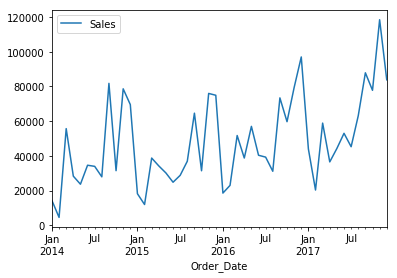

In [10]:
monthly_sales.plot()

In [11]:
import matplotlib.pyplot as plt

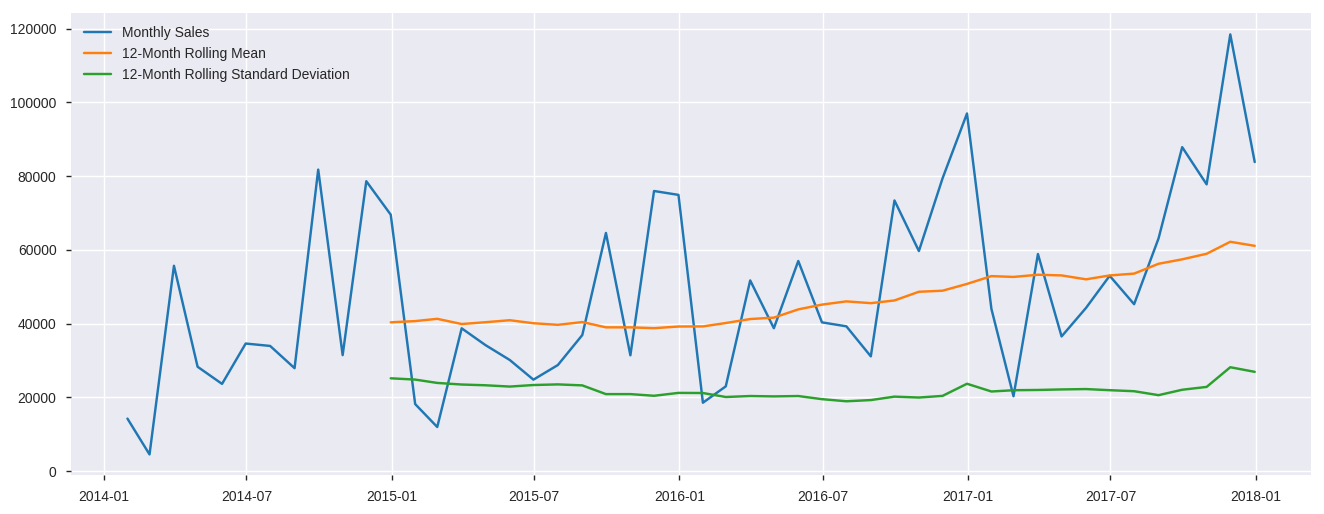

In [67]:
plt.figure(figsize=(16,6))
plt.plot(monthly_sales, label='Monthly Sales')
plt.plot(monthly_sales.rolling(window=12,center=False).mean(), label='12-Month Rolling Mean')
plt.plot(monthly_sales.rolling(window=12,center=False).std(), label='12-Month Rolling Standard Deviation')
plt.legend()

As is commom in sales data we can see an yearly seasonability. We can also see a general growth trend.

In [68]:
df.Product_Name.value_counts()[:5]

Staple envelope            48
Easy-staple paper          46
Staples                    46
Avery Non-Stick Binders    20
Staples in misc. colors    19
Name: Product_Name, dtype: int64

In [12]:
import statsmodels.api as sm

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


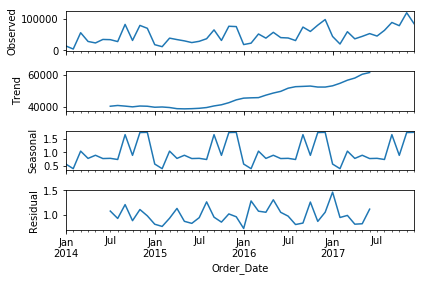

In [13]:
res = sm.tsa.seasonal_decompose(monthly_sales, freq=12, model='multiplicative')
fig = res.plot()
fig.show()

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


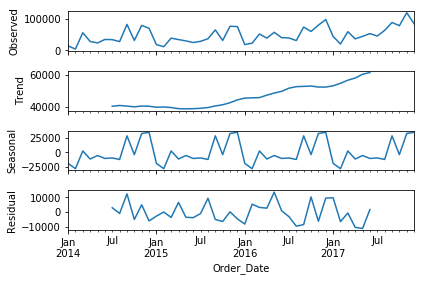

In [14]:
res = sm.tsa.seasonal_decompose(monthly_sales, freq=12, model='additive')
fig = res.plot()
fig.show()

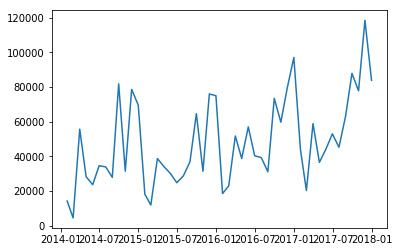

In [15]:
plt.plot(monthly_sales)

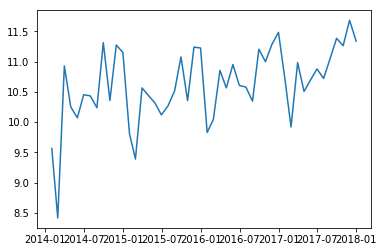

In [19]:
monthly_sales_log = np.log(monthly_sales)
plt.plot(monthly_sales_log)

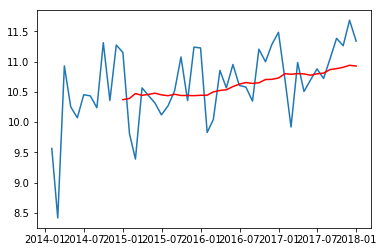

In [21]:
monthly_sales_moving_avg = monthly_sales_log.rolling(12).mean()
plt.plot(monthly_sales_log)
plt.plot(monthly_sales_moving_avg, color='red')

In [22]:
monthly_sales_moving_avg_diff = monthly_sales_log - monthly_sales_moving_avg
monthly_sales_moving_avg_diff.head(16)

,Sales
Order_Date,
2014-01-31,NaN
2014-02-28,NaN
2014-03-31,NaN
2014-04-30,NaN
2014-05-31,NaN
2014-06-30,NaN
2014-07-31,NaN
2014-08-31,NaN
2014-09-30,NaN


In [23]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

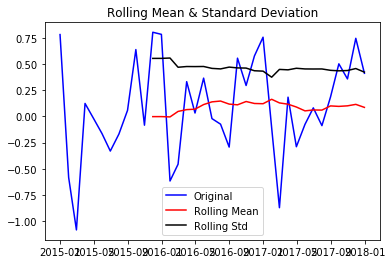

In [24]:
monthly_sales_moving_avg_diff.dropna(inplace=True)
test_stationarity(monthly_sales_moving_avg_diff)

In [82]:
monthly_sales_log.head()

,Sales
Order_Date,
2014-01-31,9.563592
2014-02-28,8.416243
2014-03-31,10.927574
2014-04-30,10.250453
2014-05-31,10.071046


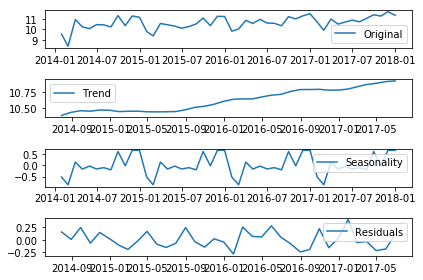

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(monthly_sales_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(monthly_sales_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

### Forecasting with Arima

The first thing to do is dicover the best parameters for Arima model

In [38]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm

In [41]:
monthly_sales_diff = monthly_sales_log - monthly_sales_log.shift()
monthly_sales_diff = monthly_sales_diff.dropna()
lag_acf = acf(monthly_sales_diff, nlags=20)
lag_pacf = pacf(monthly_sales_diff, nlags=20, method='ols')

Text(0.5, 1.0, 'Autocorrelation Function')

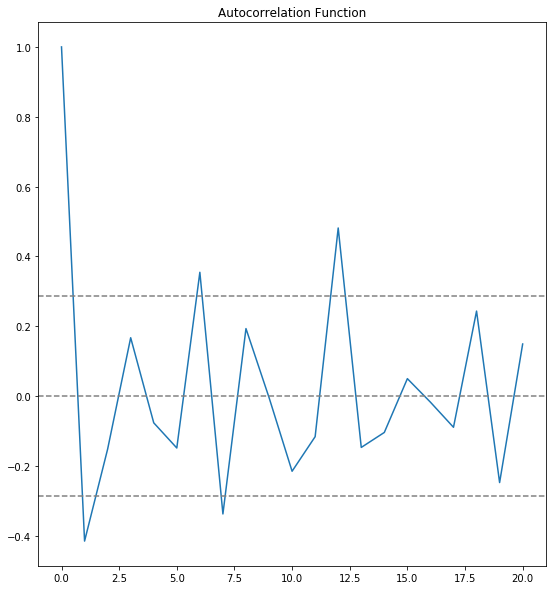

In [48]:
#Plot ACF:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(monthly_sales_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(monthly_sales_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

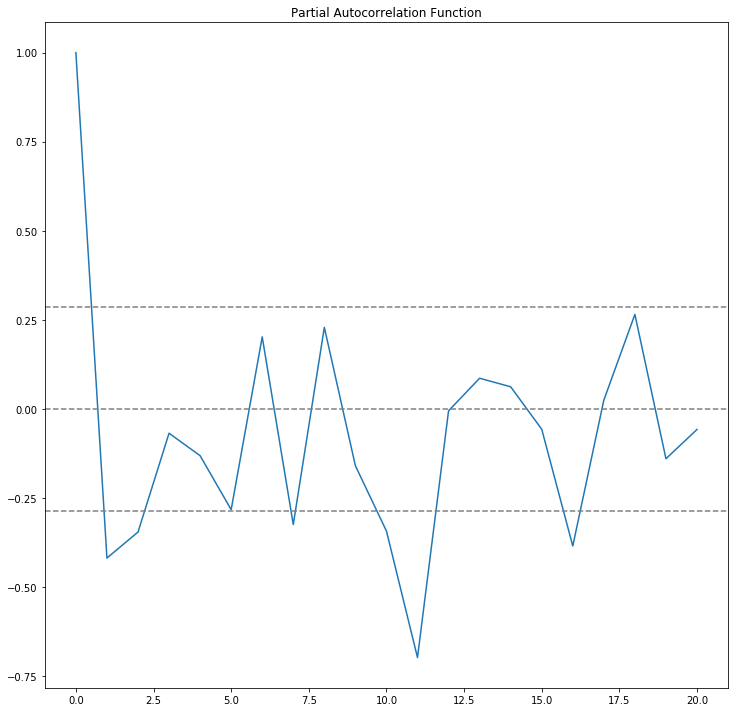

In [50]:
#Plot PACF:
plt.figure(figsize=(20,10))
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(monthly_sales_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(monthly_sales_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [52]:
from statsmodels.tsa.arima_model import ARIMA

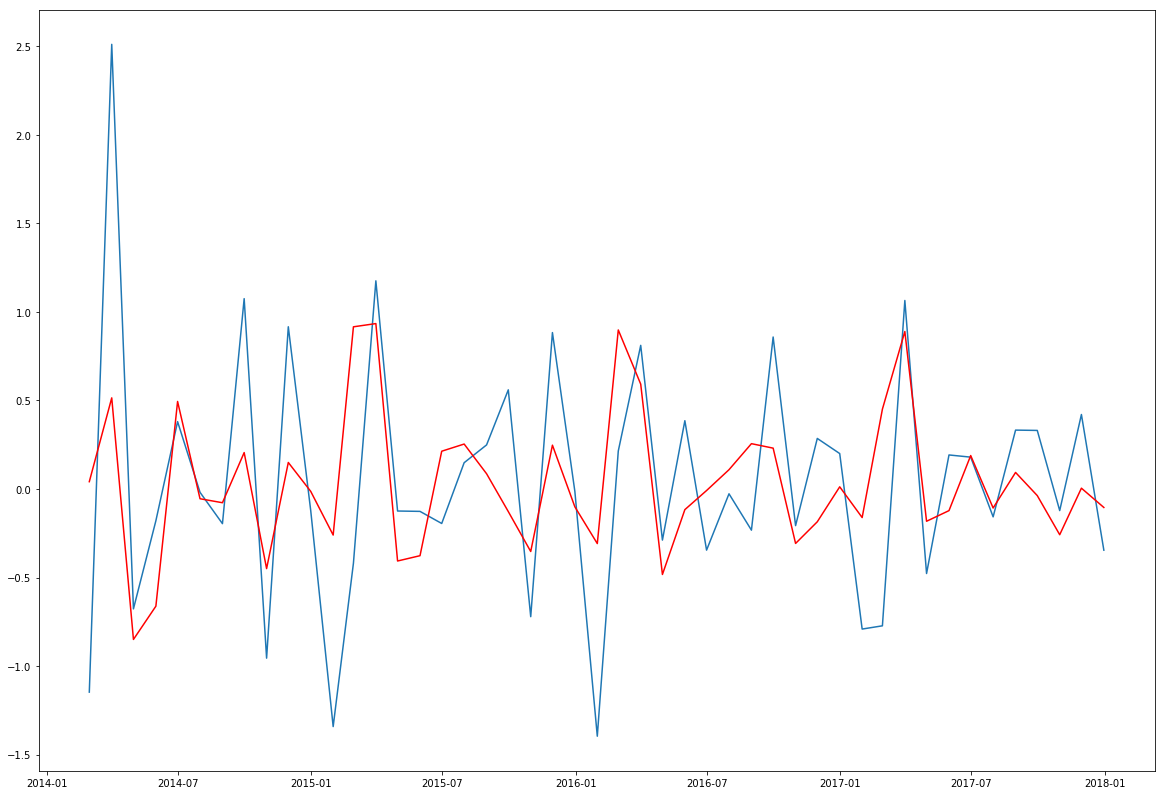

In [54]:
# MODELO AR
model = ARIMA(monthly_sales_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)
plt.figure(figsize=(20,14))
plt.plot(monthly_sales_diff)
plt.plot(results_AR.fittedvalues, color='red')

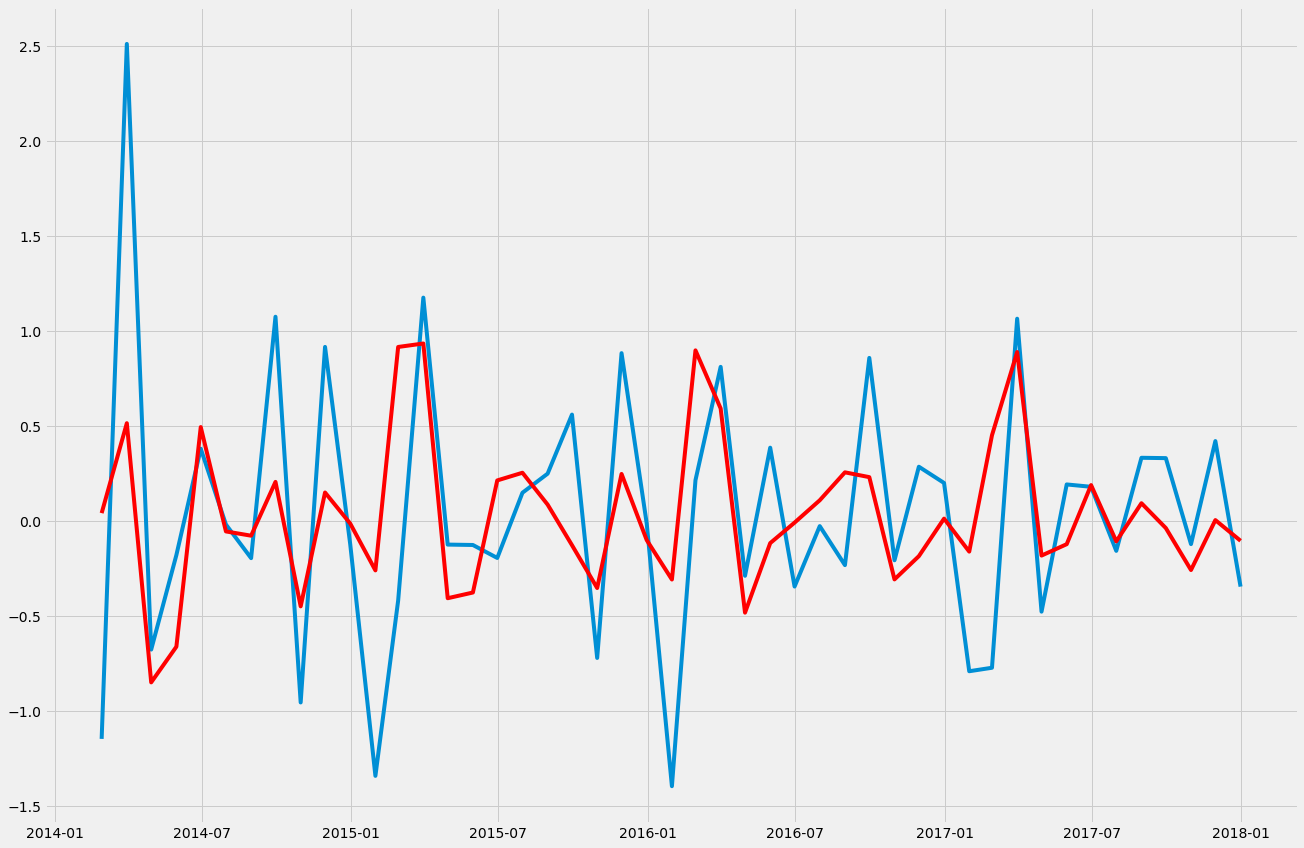

In [75]:
# MODELO MA
model = ARIMA(monthly_sales_log, order=(2, 1, 0))  
results_MA = model.fit(disp=-1)  
plt.figure(figsize=(20,14))
plt.plot(monthly_sales_diff)
plt.plot(results_MA.fittedvalues, color='red')

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


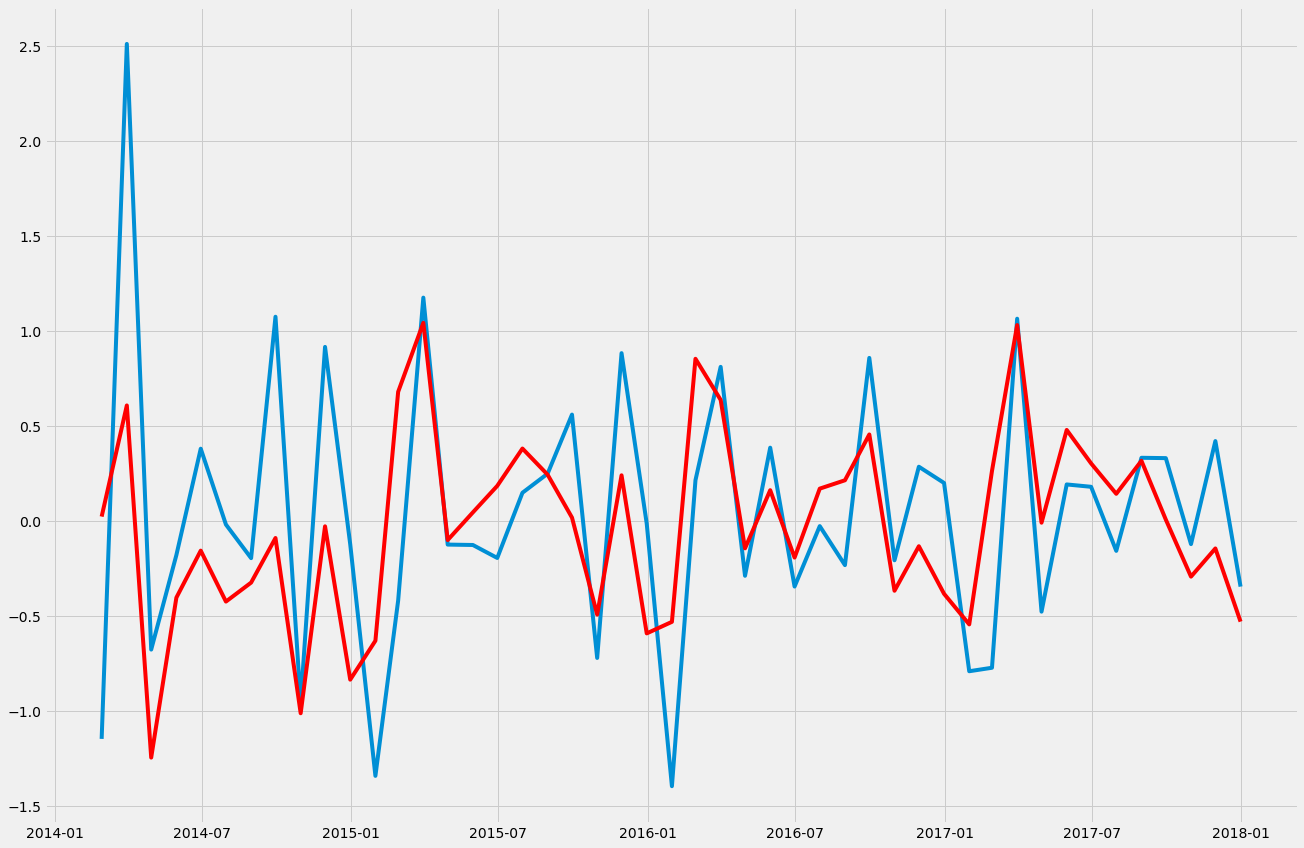

In [78]:
# Combinando AR + MA 
model = ARIMA(monthly_sales_log, order=(1, 1, 2))  
results_ARIMA = model.fit(disp=-1)
plt.figure(figsize=(20,14))
plt.plot(monthly_sales_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')

In [61]:
### Sazonalidade
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(monthly_sales_log,
                                order=(2, 1, 2),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8277      0.388     -2.131      0.033      -1.589      -0.066
ar.L2         -0.3134      0.162     -1.935      0.053      -0.631       0.004
ma.L1        -3.7e-05   2113.467  -1.75e-08      1.000   -4142.320    4142.320
ma.L2         -0.9999   1946.318     -0.001      1.000   -3815.712    3813.712
ar.S.L12      -0.3919      0.299     -1.310      0.190      -0.978       0.195
sigma2         0.0494     96.195      0.001      1.000    -188.490     188.589


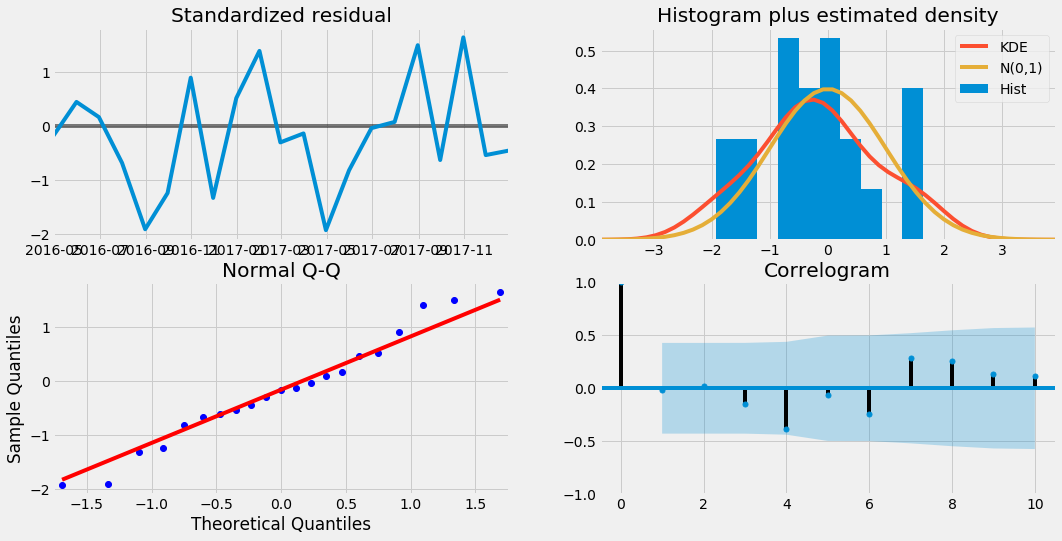

In [63]:
plt.style.use('fivethirtyeight')
results.plot_diagnostics(figsize=(16, 8))
plt.show()

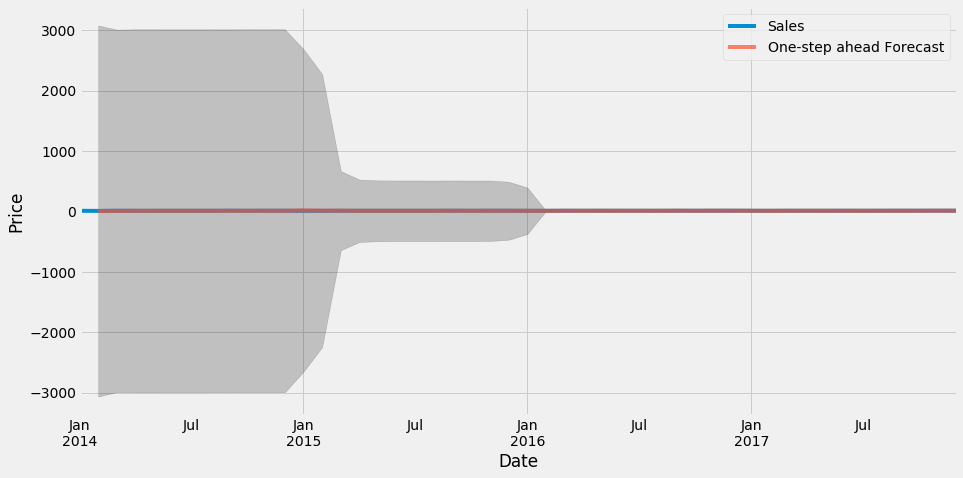

In [81]:
pred = results.get_prediction(start=pd.to_datetime('2014-02-28'), dynamic=False)
pred_ci = pred.conf_int()
ax = monthly_sales_log['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend()
plt.show()

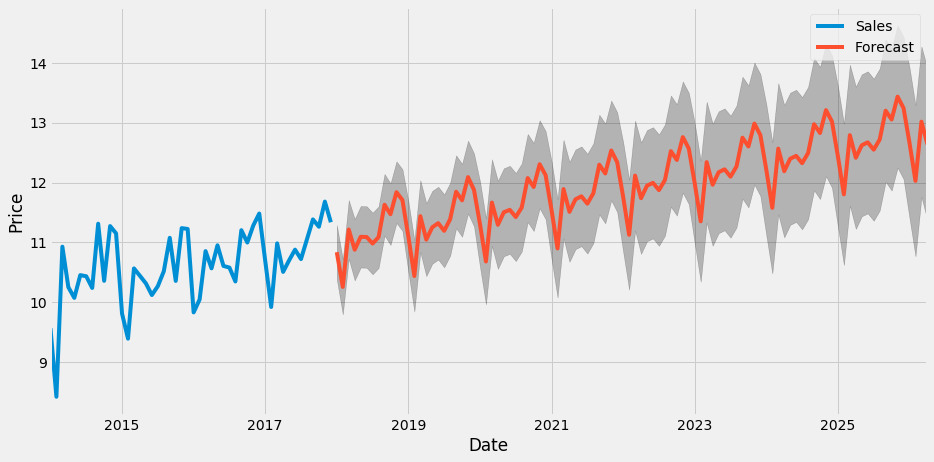

In [70]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = monthly_sales_log.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend()
plt.show()